In [51]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
from scipy.stats import zscore

In [4]:
pd

<module 'pandas' from '/home/basti/.local/share/virtualenvs/teastore_experiments-gXtBjM1O/lib/python3.9/site-packages/pandas/__init__.py'>

In [5]:
DATA_DIR = "data"

In [8]:
experiment_dirs = sorted(glob("data/*"))
experiment_dirs

exp_dir = "data/2024-06-17_09-23-43"

In [9]:
measurements = glob(exp_dir + "/*/*/*")
measurements

['data/2024-06-17_09-23-43/exp_scale/norec_feature_norecommendations_cpu/0',
 'data/2024-06-17_09-23-43/exp_scale/baseline_vanilla_cpu/0',
 'data/2024-06-17_09-23-43/exp_scale_rampup/norec_feature_norecommendations_cpu/0',
 'data/2024-06-17_09-23-43/exp_scale_rampup/baseline_vanilla_cpu/0']

In [86]:
def set_experiment_time(
    df, col="collection_time", target="experiment_time", where="run"
):
    missing_time = df[df[col] == "0"]
    print(f"{len(missing_time)} missing times")
    df.drop(missing_time.index, inplace=True)
    df[col] = pd.to_datetime(df[col])
    df["run_starts"] = df.groupby(where)[col].transform("min")
    df[target] = df[col] - df["run_starts"]
    # df['experiment_minutes'] = df[target].dt.minutes


def drop_outliers(df, z_score_threshold=4):
    data_errors = 0

    common_keys = [
        "wattage_kepler",
        "wattage_scaph",
        "cpu_usage",
        "memory_usage",
        "network_usage",
    ]

    for key in common_keys:
        df[f"{key}_zscore"] = zscore(df[key])

    for key in common_keys:
        outliers = df[df[f"{key}_zscore"].abs() > z_score_threshold].index
        data_errors += len(outliers)
        df = df.drop(outliers)

    print(f"dropped {data_errors} outliers")
    return data_errors


def measurement_file_to_df(file: str, prefix: str):
    # no risk, no fun
    (_, pr_time, pr_scale, pr_branch, pr_run, pr_name) = file.split("/")
    pod_df = pd.read_csv(file)
    pod_df["exp_workload"] = pr_scale
    pod_df["exp_branch"] = pr_branch
    pod_df["exp_run_i"] = pr_run
    pod_df["exp_id"] = pr_name.replace(prefix, "").replace(".csv", "")

    pod_df["run"] = "_".join([pr_branch, pr_scale, pr_run])

    return pod_df


def get_df_for_prefix(prefix, measurement_dirs):
    pod_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    all_pods = pd.concat([measurement_file_to_df(pf, prefix) for pf in pod_files])
    return all_pods

In [87]:
all_pods = get_df_for_prefix("measurements_pod_", measurements)
set_experiment_time(all_pods)
drop_outliers(all_pods)

all_nodes = get_df_for_prefix("measurements_node_", measurements)
set_experiment_time(all_nodes)
drop_outliers(all_nodes)

display(all_pods.describe())
display(all_nodes.describe())

all_nodes['experiment_time'].dtype

0 missing times
dropped 18 outliers
5 missing times
dropped 24 outliers


,collection_time,cpu_usage,memory_usage,network_usage,wattage_kepler,wattage_scaph,run_starts,experiment_time,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore
count,5351,5351.000000,5351.000000,0.0,5351.000000,5351.000000,5351,5351,5.351000e+03,5.351000e+03,5.351000e+03,5.351000e+03,0.0
mean,2024-06-17 09:56:08.072637184,135.407599,1136.384405,NaN,1.573029,0.000013,2024-06-17 09:48:22.329389056,0 days 00:07:45.743248192,7.170493e-17,-4.647542e-18,3.186886e-17,-1.593443e-17,NaN
min,2024-06-17 09:24:02.168830,0.000000,0.000000,NaN,0.000000,0.000000,2024-06-17 09:24:02.168830,0 days 00:00:00,-6.299679e-01,-7.617093e-02,-6.815139e-01,-1.291311e+00,NaN
25%,2024-06-17 09:41:08.718692864,2.980367,330.174464,NaN,0.000000,0.000000,2024-06-17 09:40:08.150054912,0 days 00:03:52.100606,-6.299679e-01,-7.617093e-02,-6.665135e-01,-9.161229e-01,NaN
50%,2024-06-17 09:55:47.221352960,31.492654,1048.363008,NaN,0.220000,0.000000,2024-06-17 09:40:08.150054912,0 days 00:07:44.240183,-5.418622e-01,-7.617093e-02,-5.230096e-01,-1.000216e-01,NaN
75%,2024-06-17 10:11:40.432519936,178.715026,1602.588672,NaN,3.420000,0.000000,2024-06-17 09:56:12.149262080,0 days 00:11:36.111195,7.396764e-01,-7.617093e-02,2.179687e-01,5.297633e-01,NaN
max,2024-06-17 10:27:58.472383,1432.095165,4171.784192,NaN,11.381368,0.005079,2024-06-17 10:12:20.301783,0 days 00:15:39.071329,3.928052e+00,2.897287e+01,6.526300e+00,3.449225e+00,NaN
std,NaN,198.705051,880.106007,NaN,2.497232,0.000175,NaN,0 days 00:04:29.345102099,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,NaN


,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,run_starts,experiment_time,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore
count,0.0,2236,2236.000000,2236.000000,2236.000000,2236.000000,2236.0,2236.000000,2236.000000,2236,2236,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03
mean,NaN,2024-06-17 09:55:59.302843136,472.249842,5516.620311,0.364344,15.852862,-1.0,0.011542,5.679379,2024-06-17 09:48:10.651249920,0 days 00:07:48.651593023,-4.131062e-17,-4.766610e-18,1.429983e-17,-9.215447e-17,5.561046e-18
min,NaN,2024-06-17 09:24:02.131000,33.666667,1519.116288,0.005062,0.000000,-1.0,0.000000,0.000000,2024-06-17 09:24:02.131000,0 days 00:00:00,-6.156447e-01,-7.136451e-01,-7.356537e-01,-9.782558e-01,-9.836482e-01
25%,NaN,2024-06-17 09:40:01.198250240,53.666667,1702.132736,0.024984,0.000000,-1.0,0.000000,0.000000,2024-06-17 09:36:06.615250176,0 days 00:03:52.092000,-6.156447e-01,-7.136451e-01,-7.021069e-01,-9.334686e-01,-9.291043e-01
50%,NaN,2024-06-17 09:55:59.644499968,243.000000,4387.868672,0.364170,0.000000,-1.0,0.001168,0.000000,2024-06-17 09:48:10.107500032,0 days 00:07:44.489000,-5.533242e-01,-7.136451e-01,-3.845303e-01,-2.762243e-01,-4.747567e-04
75%,NaN,2024-06-17 10:11:57.946499840,740.000000,9601.379328,0.584557,45.000000,-1.0,0.012773,16.152866,2024-06-17 10:00:14.143500032,0 days 00:11:46.347000,6.570942e-02,1.316051e+00,4.491084e-01,9.996086e-01,6.029038e-01
max,NaN,2024-06-17 10:27:58.432000,6662.000000,14483.828736,3.052864,59.000000,-1.0,0.066906,22.017046,2024-06-17 10:12:20.259000,0 days 00:15:39.074000,2.953217e+00,2.052918e+00,1.038232e+01,2.194425e+00,7.360677e+00
std,NaN,NaN,596.314902,4087.272688,0.365336,22.588118,0.0,0.018751,7.960048,NaN,0 days 00:04:33.669539259,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00


dtype('<m8[ns]')

In [61]:
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,exp_workload,exp_branch,exp_run_i,exp_id,run,experiment_time
0,ise-knode2,NaN,2024-06-17 09:40:08.110,58.666667,1656.475648,0.013104,0,-1,0.000000,0.000000,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,norec_feature_norecommendations_cpu_exp_scale_0,0 days 00:16:05.979000
1,ise-kmaster,NaN,2024-06-17 09:40:08.110,286.666667,2562.916352,0.815535,0,-1,0.000000,0.000000,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,norec_feature_norecommendations_cpu_exp_scale_0,0 days 00:16:05.979000
2,ise-knode1,NaN,2024-06-17 09:40:08.110,1533.000000,5290.123264,0.873564,0,-1,0.002039,0.138357,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,norec_feature_norecommendations_cpu_exp_scale_0,0 days 00:16:05.979000
3,ise-knode6,NaN,2024-06-17 09:40:08.110,746.666667,6141.624320,0.669945,51,-1,0.052430,16.428554,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,norec_feature_norecommendations_cpu_exp_scale_0,0 days 00:16:05.979000
4,sm-gpu,NaN,2024-06-17 09:40:08.110,529.000000,10113.032192,0.086672,49,-1,0.016379,18.951911,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,norec_feature_norecommendations_cpu_exp_scale_0,0 days 00:16:05.979000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,ise-kmaster,NaN,2024-06-17 10:11:50.509,232.333333,2563.043328,0.377906,0,-1,0.000000,0.000000,exp_scale_rampup,baseline_vanilla_cpu,0,17_06_2024_09_56,baseline_vanilla_cpu_exp_scale_rampup_0,0 days 00:47:48.378000
560,ise-knode1,NaN,2024-06-17 10:11:50.509,495.000000,8249.217024,0.786050,0,-1,0.002599,0.177521,exp_scale_rampup,baseline_vanilla_cpu,0,17_06_2024_09_56,baseline_vanilla_cpu_exp_scale_rampup_0,0 days 00:47:48.378000
561,ise-knode6,NaN,2024-06-17 10:11:50.509,734.333333,5992.480768,0.655291,45,-1,0.053509,16.391244,exp_scale_rampup,baseline_vanilla_cpu,0,17_06_2024_09_56,baseline_vanilla_cpu_exp_scale_rampup_0,0 days 00:47:48.378000
562,sm-gpu,NaN,2024-06-17 10:11:50.509,609.000000,13029.945344,0.309248,52,-1,0.015038,18.773122,exp_scale_rampup,baseline_vanilla_cpu,0,17_06_2024_09_56,baseline_vanilla_cpu_exp_scale_rampup_0,0 days 00:47:48.378000


In [42]:
all_pods.groupby(all_pods['name'])[['cpu_usage', 'memory_usage', 'wattage_kepler', 'wattage_scaph']].describe(percentiles=[])

cpu_usage                                           \
                           count        mean         std  min         50%   
name                                                                        
loadgenerator              375.0   17.103609   15.294202  0.0   14.765485   
teastore-auth-0            373.0   64.942664  107.861174  0.0   34.298027   
teastore-auth-1            186.0   31.268958   33.736809  0.0   24.725289   
teastore-auth-2             66.0  115.818144  197.046534  0.0   41.102298   
teastore-db-0              376.0   12.156537   55.095757  0.0    1.646997   
teastore-image-0           373.0  244.724824  195.342721  0.0  165.850862   
teastore-image-1           367.0  158.802346  172.963002  0.0   64.307645   
teastore-image-2           361.0  144.673978  175.659654  0.0   52.598998   
teastore-persistence-0     376.0   72.290362  180.198591  0.0   36.661389   
teastore-recommender-0     373.0   77.329238  135.994804  0.0   35.967768   
teastore-recommender-1     254.0   49.459422   87.727409  0.0   28.648027   
teastore-registry-0        376.0   26.491305   59.780276  0.0   16.496538   
teastore-webui-0           376.0  351.422299  217.854900  0.0  449.055754   
teastore-webui-1           367.0  440.924302  146.446782  0.0  449.620320   
teastore-webui-2           376.0  270.226542  255.810922  0.0  447.806545   
unknown                    376.0    0.000000    0.000000  0.0    0.000000   

                                    memory_usage                           \
                                max        count         mean         std   
name                                                                        
loadgenerator             94.402414        375.0    74.209427   20.651711   
teastore-auth-0          774.038877        373.0  1223.368506  442.558659   
teastore-auth-1          146.316489        186.0   780.542855  233.494796   
teastore-auth-2          675.413663         66.0   693.851788  168.281128   
teastore-db-0            374.021879        376.0   124.397187   42.569354   
teastore-image-0         899.815908        373.0  2216.888216  721.124354   
teastore-image-1         496.279487        367.0  1351.132163  549.833958   
teastore-image-2         517.151078        361.0  1242.716608  487.471840   
teastore-persistence-0  1432.095165        376.0  1283.917661  409.516872   
teastore-recommender-0   712.626024        373.0  1458.226722  566.121492   
teastore-recommender-1   441.303538        254.0   997.045643  335.865571   
teastore-registry-0      566.042055        376.0   420.815436  165.290469   
teastore-webui-0         900.806053        376.0  2138.610013  752.692359   
teastore-webui-1         900.731547        367.0  1656.090222  513.845745   
teastore-webui-2         901.499646        376.0  1961.339490  996.436316   
unknown                    0.000000        376.0     0.000000    0.000000   

                                    ... wattage_kepler                 \
                               min  ...            std  min       50%   
name                                ...                                 
loadgenerator             2.383872  ...       0.000000  0.0  0.000000   
teastore-auth-0         471.535616  ...       0.260564  0.0  0.233333   
teastore-auth-1         382.713856  ...       2.818737  0.0  4.563333   
teastore-auth-2          99.401728  ...       2.695195  0.0  5.409550   
teastore-db-0             3.534848  ...       0.252102  0.0  0.116667   
teastore-image-0        236.527616  ...       0.112763  0.0  0.230000   
teastore-image-1        239.144960  ...       1.892667  0.0  5.716286   
teastore-image-2         87.879680  ...       2.239688  0.0  5.720000   
teastore-persistence-0    6.090752  ...       0.147910  0.0  0.233333   
teastore-recommender-0  247.746560  ...       0.096958  0.0  0.233333   
teastore-recommender-1    0.806912  ...       3.034282  0.0  4.413333   
teastore-registry-0       5.627904  ...       0.147910  0.0  0.233333   


<Axes: xlabel='experiment_time', ylabel='wattage_scaph'>

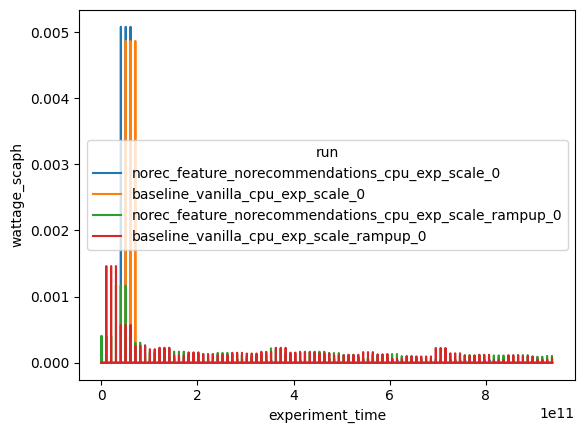

In [88]:
sns.lineplot(data=all_pods, x="experiment_time", y="wattage_scaph", hue="run")

In [45]:
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,exp_workload,exp_branch,exp_run_i,exp_run,experiment_time
0,ise-knode2,NaN,2024-06-17 09:40:08.110,58.666667,1656.475648,0.013104,0,-1,0.000000,0.000000,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,0 days 00:16:05.979000
1,ise-kmaster,NaN,2024-06-17 09:40:08.110,286.666667,2562.916352,0.815535,0,-1,0.000000,0.000000,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,0 days 00:16:05.979000
2,ise-knode1,NaN,2024-06-17 09:40:08.110,1533.000000,5290.123264,0.873564,0,-1,0.002039,0.138357,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,0 days 00:16:05.979000
3,ise-knode6,NaN,2024-06-17 09:40:08.110,746.666667,6141.624320,0.669945,51,-1,0.052430,16.428554,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,0 days 00:16:05.979000
4,sm-gpu,NaN,2024-06-17 09:40:08.110,529.000000,10113.032192,0.086672,49,-1,0.016379,18.951911,exp_scale,norec_feature_norecommendations_cpu,0,17_06_2024_09_39,0 days 00:16:05.979000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,ise-kmaster,NaN,2024-06-17 10:11:50.509,232.333333,2563.043328,0.377906,0,-1,0.000000,0.000000,exp_scale_rampup,baseline_vanilla_cpu,0,17_06_2024_09_56,0 days 00:47:48.378000
560,ise-knode1,NaN,2024-06-17 10:11:50.509,495.000000,8249.217024,0.786050,0,-1,0.002599,0.177521,exp_scale_rampup,baseline_vanilla_cpu,0,17_06_2024_09_56,0 days 00:47:48.378000
561,ise-knode6,NaN,2024-06-17 10:11:50.509,734.333333,5992.480768,0.655291,45,-1,0.053509,16.391244,exp_scale_rampup,baseline_vanilla_cpu,0,17_06_2024_09_56,0 days 00:47:48.378000
562,sm-gpu,NaN,2024-06-17 10:11:50.509,609.000000,13029.945344,0.309248,52,-1,0.015038,18.773122,exp_scale_rampup,baseline_vanilla_cpu,0,17_06_2024_09_56,0 days 00:47:48.378000


In [50]:
all_nodes.groupby(['exp_workload', 'exp_branch', 'exp_run']).describe()

observation_time  \
                                                                                 count   
exp_workload     exp_branch                          exp_run                             
exp_scale        baseline_vanilla_cpu                17_06_2024_09_23              0.0   
                 norec_feature_norecommendations_cpu 17_06_2024_09_39              0.0   
exp_scale_rampup baseline_vanilla_cpu                17_06_2024_09_56              0.0   
                 norec_feature_norecommendations_cpu 17_06_2024_10_12              0.0   

                                                                            \
                                                                      mean   
exp_workload     exp_branch                          exp_run                 
exp_scale        baseline_vanilla_cpu                17_06_2024_09_23  NaN   
                 norec_feature_norecommendations_cpu 17_06_2024_09_39  NaN   
exp_scale_rampup baseline_vanilla_cpu                17_06_2024_09_56  NaN   
                 norec_feature_norecommendations_cpu 17_06_2024_10_12  NaN   

                                                                               \
                                                                      min 25%   
exp_workload     exp_branch                          exp_run                    
exp_scale        baseline_vanilla_cpu                17_06_2024_09_23 NaN NaN   
                 norec_feature_norecommendations_cpu 17_06_2024_09_39 NaN NaN   
exp_scale_rampup baseline_vanilla_cpu                17_06_2024_09_56 NaN NaN   
                 norec_feature_norecommendations_cpu 17_06_2024_10_12 NaN NaN   

                                                                               \
                                                                      50% 75%   
exp_workload     exp_branch                          exp_run                    
exp_scale        baseline_vanilla_cpu                17_06_2024_09_23 NaN NaN   
                 norec_feature_norecommendations_cpu 17_06_2024_09_39 NaN NaN   
exp_scale_rampup baseline_vanilla_cpu                17_06_2024_09_56 NaN NaN   
                 norec_feature_norecommendations_cpu 17_06_2024_10_12 NaN NaN   

                                                                               \
                                                                      max std   
exp_workload     exp_branch                          exp_run                    
exp_scale        baseline_vanilla_cpu                17_06_2024_09_23 NaN NaN   
                 norec_feature_norecommendations_cpu 17_06_2024_09_39 NaN NaN   
exp_scale_rampup baseline_vanilla_cpu                17_06_2024_09_56 NaN NaN   
                 norec_feature_norecommendations_cpu 17_06_2024_10_12 NaN NaN   

                                                                      collection_time  \
                                                                                count   
exp_workload     exp_branch                          exp_run                            
exp_scale        baseline_vanilla_cpu                17_06_2024_09_23             559   
                 norec_feature_norecommendations_cpu 17_06_2024_09_39             559   
exp_scale_rampup baseline_vanilla_cpu                17_06_2024_09_56             559   
                 norec_feature_norecommendations_cpu 17_06_2024_10_12             559   

                                                                                                      \
                                                                                                mean   
exp_workload     exp_branch                          exp_run                                           
exp_scale        baseline_vanilla_cpu                17_06_2024_09_23  2024-06-17 09:31:50.732511744   
                 norec_feature_norecommendations_cpu 17_06_2024_09_39  2024-06-17 09:47:57.039484672   
exp_scale_rampup baseline_vanilla_cpu       

<Axes: xlabel='experiment_time', ylabel='cpu_usage'>

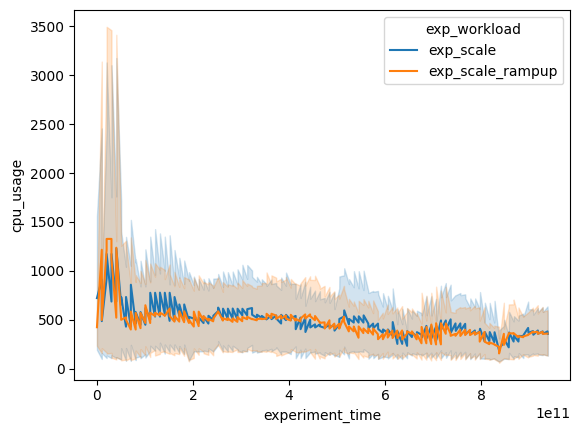

In [89]:
sns.lineplot(data=all_nodes, x="experiment_time", y="cpu_usage", hue="exp_workload")

<Axes: xlabel='experiment_time', ylabel='cpu_usage'>

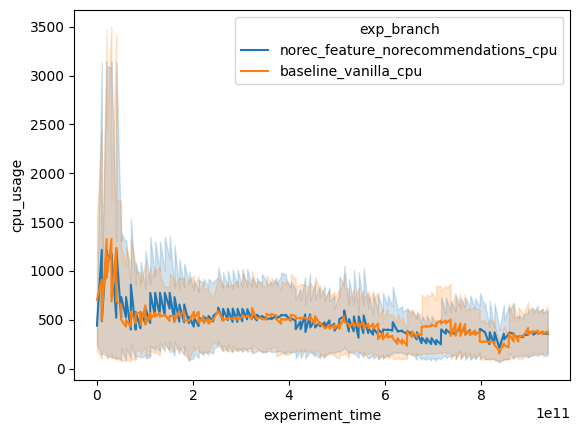

In [82]:
sns.lineplot(data=all_nodes, x="experiment_time", y="cpu_usage", hue="exp_branch")

<Axes: xlabel='experiment_time', ylabel='memory_usage'>

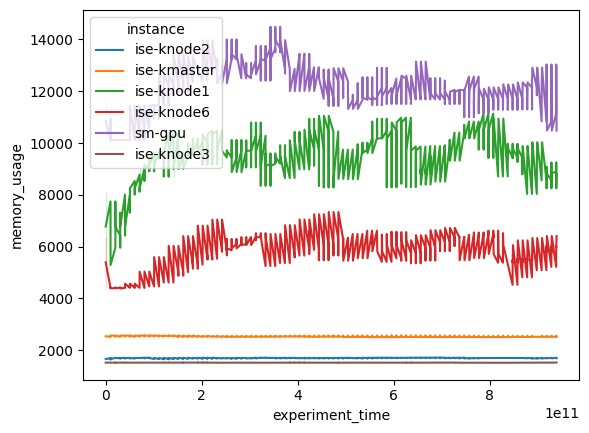

In [75]:
sns.lineplot(data=all_nodes, x="experiment_time", y="memory_usage", hue="instance")

In [76]:
all_nodes.dtypes

instance                     object
observation_time            float64
collection_time      datetime64[ns]
cpu_usage                   float64
memory_usage                float64
network_usage               float64
wattage                       int64
num_processes                 int64
wattage_kepler              float64
wattage_scaph               float64
exp_workload                 object
exp_branch                   object
exp_run_i                    object
exp_id                       object
run                          object
run_starts           datetime64[ns]
experiment_time     timedelta64[ns]
dtype: object

In [50]:
pd.to_datetime(all_nodes['collection_time'])

0    2024-06-14 14:08:41.730
1    2024-06-14 14:08:41.730
2    2024-06-14 14:08:41.730
3    2024-06-14 14:08:41.730
4    2024-06-14 14:08:41.730
               ...          
91   2024-06-14 14:11:12.594
92   2024-06-14 14:11:12.594
93   2024-06-14 14:11:12.594
94   2024-06-14 14:11:12.594
95   2024-06-14 14:11:12.594
Name: collection_time, Length: 96, dtype: datetime64[ns]

In [51]:
all_nodes['collection_time']

0     2024-06-14 14:08:41.730000
1     2024-06-14 14:08:41.730000
2     2024-06-14 14:08:41.730000
3     2024-06-14 14:08:41.730000
4     2024-06-14 14:08:41.730000
                 ...            
91    2024-06-14 14:11:12.594000
92    2024-06-14 14:11:12.594000
93    2024-06-14 14:11:12.594000
94    2024-06-14 14:11:12.594000
95    2024-06-14 14:11:12.594000
Name: collection_time, Length: 96, dtype: object